# 🏦 Experimentación Controlada con German Credit Dataset

## 📋 Objetivos del Notebook

Este notebook implementa una **experimentación controlada** enfocada en:

1. **German Credit Dataset** específicamente
2. **Optimización con Optuna** para cada modelo
3. **Métricas detalladas**: AUC, PSI, Traffic Light
4. **Comparación entre**: Train, Test, Holdout
5. **Análisis por algoritmo** individual

## 🎯 Métricas de Evaluación

### Métricas Principales:
- **AUC-ROC**: Capacidad discriminante del modelo
- **PSI (Population Stability Index)**: Estabilidad de distribución entre muestras
- **Traffic Light**: Precisión en grupos de riesgo para rating bancario

### Traffic Light Methodology:
- **Verde**: Modelo predice correctamente la probabilidad de default
- **Amarillo**: Subestimación o sobrestimación leve
- **Rojo**: Subestimación o sobrestimación significativa

## 🚀 Modelos a Optimizar

1. **XGBoost** - Gradient Boosting optimizado
2. **CatBoost** - Gradient Boosting con manejo de categóricas
3. **LightGBM** - Gradient Boosting eficiente
4. **RandomForest** - Ensemble de árboles
5. **LogisticRegression** - Modelo lineal baseline

## 📊 Estructura de Evaluación

Para cada modelo optimizado:
- **Train Performance**: Métricas en datos de entrenamiento
- **Test Performance**: Métricas en datos de prueba
- **Holdout Performance**: Métricas en datos de validación
- **Comparación**: Análisis de estabilidad y generalización

---

**¡Empecemos con la experimentación controlada!** 🎯


In [1]:
# Importación de librerías
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import yaml
import logging
from tqdm import tqdm
import time
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Modelos específicos
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# UCI Repository
from ucimlrepo import fetch_ucirepo

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Librerías importadas correctamente")


C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Librerías importadas correctamente


In [ ]:
# Configuración del proyecto
PROJECT_ROOT = Path('..')
DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'
CONFIGS_DIR = PROJECT_ROOT / 'configs'

# Crear directorios si no existen
DATA_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

# Configuración de experimento
RANDOM_STATE = 42
N_TRIALS = 100  # Aumentado para grillas más finas
CV_FOLDS = 5   # Folds para cross-validation

print(f"📁 Directorio del proyecto: {PROJECT_ROOT.absolute()}")
print(f"📊 Número de trials Optuna: {N_TRIALS}")
print(f"🔄 Folds de CV: {CV_FOLDS}")


📁 Directorio del proyecto: c:\Users\carlo\OneDrive\Documentos\repos\tb-grado-repo\notebooks\..
📊 Número de trials Optuna: 50
🔄 Folds de CV: 5


In [3]:
# Cargar German Credit Dataset
print("📥 Cargando German Credit Dataset...")

try:
    # Cargar dataset desde UCI Repository
    german_credit = fetch_ucirepo(id=144)
    
    # Obtener datos
    X = german_credit.data.features
    y = german_credit.data.targets
    
    print(f"✅ Dataset cargado exitosamente")
    print(f"   📊 Forma de X: {X.shape}")
    print(f"   📊 Forma de y: {y.shape}")
    print(f"   🎯 Variable objetivo: {y.columns[0]}")
    
    # Mostrar información del dataset
    print(f"\n📋 Información del dataset:")
    print(f"   Features: {list(X.columns)}")
    print(f"   Tipos de datos: {X.dtypes.value_counts().to_dict()}")
    print(f"   Valores únicos en target: {y.iloc[:, 0].value_counts().to_dict()}")
    
except Exception as e:
    print(f"❌ Error cargando dataset: {e}")
    print("🔄 Intentando cargar desde archivo local...")
    
    # Intentar cargar desde archivo local si existe
    local_file = DATA_DIR / 'german_credit.csv'
    if local_file.exists():
        df = pd.read_csv(local_file)
        X = df.drop('target', axis=1)
        y = df[['target']]
        print(f"✅ Dataset cargado desde archivo local")
    else:
        print(f"❌ No se pudo cargar el dataset")
        raise


📥 Cargando German Credit Dataset...
✅ Dataset cargado exitosamente
   📊 Forma de X: (1000, 20)
   📊 Forma de y: (1000, 1)
   🎯 Variable objetivo: class

📋 Información del dataset:
   Features: ['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4', 'Attribute5', 'Attribute6', 'Attribute7', 'Attribute8', 'Attribute9', 'Attribute10', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute14', 'Attribute15', 'Attribute16', 'Attribute17', 'Attribute18', 'Attribute19', 'Attribute20']
   Tipos de datos: {dtype('O'): 13, dtype('int64'): 7}
   Valores únicos en target: {1: 700, 2: 300}


In [4]:
# Preprocesamiento de datos
print("🔧 Preprocesando datos...")

# Convertir target a binario (1 = bad credit, 0 = good credit)
y_binary = (y.iloc[:, 0] == 2).astype(int)  # 2 = bad credit en German dataset

print(f"📊 Distribución del target:")
print(f"   Good Credit (0): {(y_binary == 0).sum()} ({(y_binary == 0).mean()*100:.1f}%)")
print(f"   Bad Credit (1): {(y_binary == 1).sum()} ({(y_binary == 1).mean()*100:.1f}%)")

# Identificar variables categóricas y numéricas
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\n📋 Tipos de variables:")
print(f"   Categóricas: {len(categorical_cols)} - {categorical_cols}")
print(f"   Numéricas: {len(numerical_cols)} - {numerical_cols}")

# Codificar variables categóricas
X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"✅ Variables categóricas codificadas")
print(f"📊 Forma final: {X_encoded.shape}")


🔧 Preprocesando datos...
📊 Distribución del target:
   Good Credit (0): 700 (70.0%)
   Bad Credit (1): 300 (30.0%)

📋 Tipos de variables:
   Categóricas: 13 - ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute6', 'Attribute7', 'Attribute9', 'Attribute10', 'Attribute12', 'Attribute14', 'Attribute15', 'Attribute17', 'Attribute19', 'Attribute20']
   Numéricas: 7 - ['Attribute2', 'Attribute5', 'Attribute8', 'Attribute11', 'Attribute13', 'Attribute16', 'Attribute18']
✅ Variables categóricas codificadas
📊 Forma final: (1000, 20)


In [5]:
# División de datos: Train (60%) / Test (20%) / Holdout (20%)
print("📊 Dividiendo datos en Train/Test/Holdout...")

# Primera división: Train+Test (80%) / Holdout (20%)
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X_encoded, y_binary, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y_binary
)

# Segunda división: Train (60%) / Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 0.25 de 0.8 = 0.2 del total
    random_state=RANDOM_STATE, 
    stratify=y_temp
)

print(f"✅ División de datos completada:")
print(f"   🏋️ Train: {X_train.shape[0]} muestras (60%)")
print(f"   🧪 Test: {X_test.shape[0]} muestras (20%)")
print(f"   🔒 Holdout: {X_holdout.shape[0]} muestras (20%)")

# Verificar distribución del target en cada conjunto
print(f"\n📊 Distribución del target por conjunto:")
for name, y_set in [('Train', y_train), ('Test', y_test), ('Holdout', y_holdout)]:
    bad_rate = y_set.mean()
    print(f"   {name}: {bad_rate:.3f} ({y_set.sum()}/{len(y_set)})")


📊 Dividiendo datos en Train/Test/Holdout...
✅ División de datos completada:
   🏋️ Train: 600 muestras (60%)
   🧪 Test: 200 muestras (20%)
   🔒 Holdout: 200 muestras (20%)

📊 Distribución del target por conjunto:
   Train: 0.300 (180/600)
   Test: 0.300 (60/200)
   Holdout: 0.300 (60/200)


In [6]:
# Clase para métricas de evaluación
class CreditScoringMetrics:
    """
    Clase para calcular métricas específicas de scoring crediticio
    """
    
    @staticmethod
    def calculate_auc_roc(y_true, y_pred_proba):
        """
        Calcula AUC-ROC
        """
        return roc_auc_score(y_true, y_pred_proba)
    
    @staticmethod
    def calculate_psi(expected, actual, bins=10):
        """
        Calcula Population Stability Index (PSI)
        
        Args:
            expected: Distribución esperada (train)
            actual: Distribución actual (test/holdout)
            bins: Número de bins para discretizar
        
        Returns:
            PSI value
        """
        # Crear bins basados en la distribución esperada
        breakpoints = np.linspace(0, 1, bins + 1)
        breakpoints[0] = -np.inf
        breakpoints[-1] = np.inf
        
        # Discretizar ambas distribuciones
        expected_binned = pd.cut(expected, bins=breakpoints, labels=False)
        actual_binned = pd.cut(actual, bins=breakpoints, labels=False)
        
        # Calcular frecuencias
        expected_freq = pd.Series(expected_binned).value_counts(normalize=True, sort=False)
        actual_freq = pd.Series(actual_binned).value_counts(normalize=True, sort=False)
        
        # Asegurar que ambos tengan los mismos bins
        for i in range(bins):
            if i not in expected_freq.index:
                expected_freq[i] = 0
            if i not in actual_freq.index:
                actual_freq[i] = 0
        
        expected_freq = expected_freq.sort_index()
        actual_freq = actual_freq.sort_index()
        
        # Calcular PSI
        psi = 0
        for i in range(bins):
            if expected_freq.iloc[i] > 0:
                psi += (actual_freq.iloc[i] - expected_freq.iloc[i]) * \
                       np.log(actual_freq.iloc[i] / expected_freq.iloc[i])
        
        return psi
    
    @staticmethod
    def calculate_traffic_light(y_true, y_pred_proba, n_groups=10):
        """
        Calcula Traffic Light para grupos de riesgo
        
        Args:
            y_true: Valores reales
            y_pred_proba: Probabilidades predichas
            n_groups: Número de grupos de riesgo
        
        Returns:
            Dict con estadísticas de Traffic Light
        """
        # Crear grupos de riesgo basados en probabilidades predichas
        df = pd.DataFrame({
            'actual': y_true,
            'predicted': y_pred_proba
        })
        
        # Ordenar por probabilidad predicha (descendente)
        df = df.sort_values('predicted', ascending=False).reset_index(drop=True)
        
        # Crear grupos de riesgo
        group_size = len(df) // n_groups
        df['group'] = 0
        
        for i in range(n_groups):
            start_idx = i * group_size
            if i == n_groups - 1:  # Último grupo incluye el resto
                end_idx = len(df)
            else:
                end_idx = (i + 1) * group_size
            
            df.loc[start_idx:end_idx-1, 'group'] = i + 1
        
        # Calcular métricas por grupo
        group_stats = []
        for group in range(1, n_groups + 1):
            group_data = df[df['group'] == group]
            if len(group_data) > 0:
                actual_rate = group_data['actual'].mean()
                predicted_rate = group_data['predicted'].mean()
                
                # Determinar color del semáforo
                diff = abs(actual_rate - predicted_rate)
                if diff <= 0.05:  # 5% de tolerancia
                    color = 'green'
                elif diff <= 0.10:  # 10% de tolerancia
                    color = 'yellow'
                else:
                    color = 'red'
                
                group_stats.append({
                    'group': group,
                    'actual_rate': actual_rate,
                    'predicted_rate': predicted_rate,
                    'difference': diff,
                    'color': color,
                    'size': len(group_data)
                })
        
        # Calcular estadísticas generales
        colors = [stat['color'] for stat in group_stats]
        green_pct = colors.count('green') / len(colors) * 100
        yellow_pct = colors.count('yellow') / len(colors) * 100
        red_pct = colors.count('red') / len(colors) * 100
        
        return {
            'group_stats': group_stats,
            'green_percentage': green_pct,
            'yellow_percentage': yellow_pct,
            'red_percentage': red_pct,
            'total_groups': len(group_stats)
        }
    
    @classmethod
    def evaluate_model(cls, y_true, y_pred_proba, y_train_proba=None):
        """
        Evalúa un modelo con todas las métricas
        
        Args:
            y_true: Valores reales
            y_pred_proba: Probabilidades predichas
            y_train_proba: Probabilidades en train (para PSI)
        
        Returns:
            Dict con todas las métricas
        """
        results = {}
        
        # AUC-ROC
        results['auc_roc'] = cls.calculate_auc_roc(y_true, y_pred_proba)
        
        # PSI (si se proporcionan datos de train)
        if y_train_proba is not None:
            results['psi'] = cls.calculate_psi(y_train_proba, y_pred_proba)
        
        # Traffic Light
        traffic_light = cls.calculate_traffic_light(y_true, y_pred_proba)
        results['traffic_light'] = traffic_light
        
        return results

print("✅ Clase de métricas creada")


✅ Clase de métricas creada


In [ ]:
# Clase para optimización con Optuna
class OptunaOptimizer:
    """
    Clase para optimizar modelos con Optuna
    """
    
    def __init__(self, X_train, y_train, cv_folds=5, n_trials=50):
        self.X_train = X_train
        self.y_train = y_train
        self.cv_folds = cv_folds
        self.n_trials = n_trials
        self.best_params = {}
        self.best_scores = {}
        
    def optimize_xgboost(self):
        """
        Optimiza XGBoost con Optuna - Enfocado en reducir overfitting
        """
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Reducido
                'max_depth': trial.suggest_int('max_depth', 2, 6),  # Más restrictivo
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),  # Más conservador
                'subsample': trial.suggest_float('subsample', 0.7, 0.9),  # Más regularización
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),  # Más regularización
                'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0),  # L1 regularización
                'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0),  # L2 regularización
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Control de overfitting
                'gamma': trial.suggest_float('gamma', 0, 2),  # Regularización adicional
                'random_state': RANDOM_STATE,
                'early_stopping_rounds': 20,  # Early stopping
                'eval_metric': 'logloss'
            }
            
            model = xgb.XGBClassifier(**params)
            cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                      cv=self.cv_folds, scoring='roc_auc')
            return cv_scores.mean()
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=self.n_trials)
        
        self.best_params['xgboost'] = study.best_params
        self.best_scores['xgboost'] = study.best_value
        
        return study.best_params
    
    def optimize_lightgbm(self):
        """
        Optimiza LightGBM con Optuna - Enfocado en reducir overfitting
        """
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Reducido
                'max_depth': trial.suggest_int('max_depth', 2, 6),  # Más restrictivo
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),  # Más conservador
                'subsample': trial.suggest_float('subsample', 0.7, 0.9),  # Más regularización
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),  # Más regularización
                'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5.0),  # L1 regularización
                'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0),  # L2 regularización
                'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),  # Control de overfitting
                'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),  # Regularización adicional
                'random_state': RANDOM_STATE,
                'verbose': -1,
                'early_stopping_rounds': 20  # Early stopping
            }
            
            model = lgb.LGBMClassifier(**params)
            cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                      cv=self.cv_folds, scoring='roc_auc')
            return cv_scores.mean()
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=self.n_trials)
        
        self.best_params['lightgbm'] = study.best_params
        self.best_scores['lightgbm'] = study.best_value
        
        return study.best_params
    
    def optimize_catboost(self):
        """
        Optimiza CatBoost con Optuna - Enfocado en reducir overfitting
        """
        def objective(trial):
            params = {
                'iterations': trial.suggest_int('iterations', 50, 300),  # Reducido
                'depth': trial.suggest_int('depth', 2, 6),  # Más restrictivo
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),  # Más conservador
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),  # L2 regularización
                'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
                'subsample': trial.suggest_float('subsample', 0.7, 0.9),  # Más regularización
                'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.9),  # Regularización
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),  # Control de overfitting
                'random_seed': RANDOM_STATE,
                'verbose': False,
                'early_stopping_rounds': 20  # Early stopping
            }
            
            model = cb.CatBoostClassifier(**params)
            cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                      cv=self.cv_folds, scoring='roc_auc')
            return cv_scores.mean()
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=self.n_trials)
        
        self.best_params['catboost'] = study.best_params
        self.best_scores['catboost'] = study.best_value
        
        return study.best_params
    
    def optimize_random_forest(self):
        """
        Optimiza Random Forest con Optuna - Enfocado en reducir overfitting
        """
        def objective(trial):
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Reducido
                'max_depth': trial.suggest_int('max_depth', 3, 10),  # Más restrictivo
                'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),  # Más restrictivo
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),  # Más restrictivo
                'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  # Sin None
                'bootstrap': True,  # Bootstrap para regularización
                'max_samples': trial.suggest_float('max_samples', 0.7, 0.9),  # Submuestreo
                'random_state': RANDOM_STATE
            }
            
            model = RandomForestClassifier(**params)
            cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                      cv=self.cv_folds, scoring='roc_auc')
            return cv_scores.mean()
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=self.n_trials)
        
        self.best_params['random_forest'] = study.best_params
        self.best_scores['random_forest'] = study.best_value
        
        return study.best_params
    
    def optimize_logistic_regression(self):
        """
        Optimiza Logistic Regression con Optuna - Enfocado en reducir overfitting
        """
        def objective(trial):
            params = {
                'C': trial.suggest_float('C', 0.01, 10, log=True),  # Más restrictivo
                'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet']),
                'solver': 'saga',  # Compatible con elasticnet
                'l1_ratio': trial.suggest_float('l1_ratio', 0.1, 0.9),  # Para elasticnet
                'max_iter': 1000,  # Más iteraciones
                'random_state': RANDOM_STATE
            }
            
            model = LogisticRegression(**params)
            cv_scores = cross_val_score(model, self.X_train, self.y_train, 
                                      cv=self.cv_folds, scoring='roc_auc')
            return cv_scores.mean()
        
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=self.n_trials)
        
        self.best_params['logistic_regression'] = study.best_params
        self.best_scores['logistic_regression'] = study.best_value
        
        return study.best_params

print("✅ Clase de optimización creada")


✅ Clase de optimización creada


In [8]:
# Inicializar optimizador
optimizer = OptunaOptimizer(X_train, y_train, cv_folds=CV_FOLDS, n_trials=N_TRIALS)

print(f"🚀 Optimizador inicializado")
print(f"   📊 Datos de entrenamiento: {X_train.shape}")
print(f"   🔄 Folds de CV: {CV_FOLDS}")
print(f"   🎯 Trials por modelo: {N_TRIALS}")


🚀 Optimizador inicializado
   📊 Datos de entrenamiento: (600, 20)
   🔄 Folds de CV: 5
   🎯 Trials por modelo: 50


In [9]:
# Optimizar todos los modelos
print("🔥 OPTIMIZANDO TODOS LOS MODELOS...")
print("="*50)

# Lista de modelos a optimizar
models_to_optimize = [
    ('XGBoost', optimizer.optimize_xgboost),
    ('LightGBM', optimizer.optimize_lightgbm),
    ('CatBoost', optimizer.optimize_catboost),
    ('RandomForest', optimizer.optimize_random_forest),
    ('LogisticRegression', optimizer.optimize_logistic_regression)
]

# Optimizar cada modelo
for model_name, optimize_func in models_to_optimize:
    print(f"\n🔥 Optimizando {model_name}...")
    start_time = time.time()
    
    try:
        best_params = optimize_func()
        end_time = time.time()
        
        print(f"✅ {model_name} optimizado en {end_time - start_time:.1f} segundos")
        print(f"   🏆 Mejor CV Score: {optimizer.best_scores[model_name.lower().replace(' ', '_')]:.4f}")
        print(f"   ⚙️ Mejores parámetros: {best_params}")
        
    except Exception as e:
        print(f"❌ Error optimizando {model_name}: {e}")

print(f"\n✅ Optimización completada para todos los modelos")


[I 2025-10-17 14:06:39,279] A new study created in memory with name: no-name-6f538121-5d50-4d0a-9489-a9a14750a5a1


🔥 OPTIMIZANDO TODOS LOS MODELOS...

🔥 Optimizando XGBoost...


[I 2025-10-17 14:06:41,829] Trial 0 finished with value: 0.7916666666666666 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 0.7916666666666666.
[I 2025-10-17 14:06:45,437] Trial 1 finished with value: 0.7979497354497355 and parameters: {'n_estimators': 880, 'max_depth': 7, 'learning_rate': 0.21534104756085318, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 0.7979497354497355.
[I 2025-10-17 14:06:46,551] Trial 2 finished with value: 0.8022486772486772 and parameters: {'n_estimators': 263, 'max_depth': 4, 'learning_rate': 0.09823025045826593, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 2.9122914019804194, 'reg_lambda':

✅ XGBoost optimizado en 127.0 segundos
   🏆 Mejor CV Score: 0.8100
   ⚙️ Mejores parámetros: {'n_estimators': 926, 'max_depth': 9, 'learning_rate': 0.08590987126556161, 'subsample': 0.699457553196542, 'colsample_bytree': 0.8214965975114662, 'reg_alpha': 8.28558792008156, 'reg_lambda': 1.8379333980560153}

🔥 Optimizando LightGBM...


[I 2025-10-17 14:08:46,826] Trial 0 finished with value: 0.7885582010582011 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 0.7885582010582011.
[I 2025-10-17 14:08:47,162] Trial 1 finished with value: 0.7839285714285714 and parameters: {'n_estimators': 880, 'max_depth': 7, 'learning_rate': 0.21534104756085318, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 0 with value: 0.7885582010582011.
[I 2025-10-17 14:08:47,470] Trial 2 finished with value: 0.7935185185185185 and parameters: {'n_estimators': 263, 'max_depth': 4, 'learning_rate': 0.09823025045826593, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 2.9122914019804194, 'reg_lambda':

✅ LightGBM optimizado en 22.2 segundos
   🏆 Mejor CV Score: 0.7946
   ⚙️ Mejores parámetros: {'n_estimators': 259, 'max_depth': 6, 'learning_rate': 0.058940175085545464, 'subsample': 0.7282727725096664, 'colsample_bytree': 0.737599786130496, 'reg_alpha': 3.502177540009103, 'reg_lambda': 6.964113560962283}

🔥 Optimizando CatBoost...


[I 2025-10-17 14:09:43,229] Trial 0 finished with value: 0.7895502645502646 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.22227824312530747, 'l2_leaf_reg': 6.387926357773329}. Best is trial 0 with value: 0.7895502645502646.
[I 2025-10-17 14:09:46,617] Trial 1 finished with value: 0.796957671957672 and parameters: {'iterations': 240, 'depth': 4, 'learning_rate': 0.026844247528777843, 'l2_leaf_reg': 8.795585311974417}. Best is trial 1 with value: 0.796957671957672.
[I 2025-10-17 14:10:06,610] Trial 2 finished with value: 0.8082671957671957 and parameters: {'iterations': 641, 'depth': 8, 'learning_rate': 0.01596950334578271, 'l2_leaf_reg': 9.72918866945795}. Best is trial 2 with value: 0.8082671957671957.
[I 2025-10-17 14:10:18,729] Trial 3 finished with value: 0.784457671957672 and parameters: {'iterations': 850, 'depth': 4, 'learning_rate': 0.06272924049005918, 'l2_leaf_reg': 2.650640588680904}. Best is trial 2 with value: 0.8082671957671957.
[I 2025-10-17 14:10:27

✅ CatBoost optimizado en 1011.6 segundos
   🏆 Mejor CV Score: 0.8090
   ⚙️ Mejores parámetros: {'iterations': 936, 'depth': 7, 'learning_rate': 0.011115348668807668, 'l2_leaf_reg': 9.539128775945453}

🔥 Optimizando RandomForest...


[I 2025-10-17 14:26:06,230] Trial 0 finished with value: 0.8130291005291006 and parameters: {'n_estimators': 437, 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8130291005291006.
[I 2025-10-17 14:26:20,012] Trial 1 finished with value: 0.815410052910053 and parameters: {'n_estimators': 880, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.815410052910053.
[I 2025-10-17 14:26:24,875] Trial 2 finished with value: 0.8089285714285716 and parameters: {'n_estimators': 263, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.815410052910053.
[I 2025-10-17 14:26:28,043] Trial 3 finished with value: 0.817195767195767 and parameters: {'n_estimators': 225, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.817195767195767.
[I 

✅ RandomForest optimizado en 573.2 segundos
❌ Error optimizando RandomForest: 'randomforest'

🔥 Optimizando LogisticRegression...


[I 2025-10-17 14:35:33,505] Trial 2 finished with value: 0.733994708994709 and parameters: {'C': 0.017073967431528128, 'penalty': 'l1'}. Best is trial 0 with value: 0.8018518518518519.
[I 2025-10-17 14:35:33,580] Trial 3 finished with value: 0.803505291005291 and parameters: {'C': 6.79657809075816, 'penalty': 'l2'}. Best is trial 3 with value: 0.803505291005291.
[I 2025-10-17 14:35:33,680] Trial 4 finished with value: 0.7939814814814815 and parameters: {'C': 21.368329072358772, 'penalty': 'l1'}. Best is trial 3 with value: 0.803505291005291.
[I 2025-10-17 14:35:33,752] Trial 5 finished with value: 0.8061507936507937 and parameters: {'C': 0.05415244119402541, 'penalty': 'l2'}. Best is trial 5 with value: 0.8061507936507937.
[I 2025-10-17 14:35:33,851] Trial 6 finished with value: 0.8018518518518519 and parameters: {'C': 0.5342937261279778, 'penalty': 'l2'}. Best is trial 5 with value: 0.8061507936507937.
[I 2025-10-17 14:35:33,935] Trial 7 finished with value: 0.8042989417989419 and par

✅ LogisticRegression optimizado en 4.2 segundos
❌ Error optimizando LogisticRegression: 'logisticregression'

✅ Optimización completada para todos los modelos


In [10]:
# Resumen de optimización
print("📊 RESUMEN DE OPTIMIZACIÓN")
print("="*50)

for model_name, score in optimizer.best_scores.items():
    print(f"{model_name.upper()}: {score:.4f}")

# Encontrar el mejor modelo
best_model_name = max(optimizer.best_scores, key=optimizer.best_scores.get)
best_score = optimizer.best_scores[best_model_name]

print(f"\n🏆 MEJOR MODELO: {best_model_name.upper()}")
print(f"📊 Mejor CV Score: {best_score:.4f}")


📊 RESUMEN DE OPTIMIZACIÓN
XGBOOST: 0.8100
LIGHTGBM: 0.7946
CATBOOST: 0.8090
RANDOM_FOREST: 0.8199
LOGISTIC_REGRESSION: 0.8068

🏆 MEJOR MODELO: RANDOM_FOREST
📊 Mejor CV Score: 0.8199


In [ ]:
# Entrenar modelos optimizados y evaluar
print("🏋️ Entrenando modelos optimizados...")

# Crear modelos con mejores parámetros (removiendo parámetros de early stopping para entrenamiento final)
def clean_params_for_training(params, model_type):
    """Limpia parámetros para entrenamiento final"""
    cleaned = params.copy()
    
    # Remover parámetros de early stopping que no se usan en fit()
    if 'early_stopping_rounds' in cleaned:
        del cleaned['early_stopping_rounds']
    if 'eval_metric' in cleaned:
        del cleaned['eval_metric']
    
    return cleaned

models = {
    'XGBoost': xgb.XGBClassifier(**clean_params_for_training(optimizer.best_params['xgboost'], 'xgboost'), random_state=RANDOM_STATE),
    'LightGBM': lgb.LGBMClassifier(**clean_params_for_training(optimizer.best_params['lightgbm'], 'lightgbm'), random_state=RANDOM_STATE, verbose=-1),
    'CatBoost': cb.CatBoostClassifier(**clean_params_for_training(optimizer.best_params['catboost'], 'catboost'), random_seed=RANDOM_STATE, verbose=False),
    'RandomForest': RandomForestClassifier(**optimizer.best_params['random_forest'], random_state=RANDOM_STATE),
    'LogisticRegression': LogisticRegression(**optimizer.best_params['logistic_regression'], random_state=RANDOM_STATE)
}

# Entrenar todos los modelos
trained_models = {}
for name, model in models.items():
    print(f"   Entrenando {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model

print("✅ Todos los modelos entrenados")


🏋️ Entrenando modelos optimizados...
   Entrenando XGBoost...
   Entrenando LightGBM...
   Entrenando CatBoost...
   Entrenando RandomForest...
   Entrenando LogisticRegression...
✅ Todos los modelos entrenados


In [12]:
# Evaluar modelos en Train, Test y Holdout
print("📊 EVALUANDO MODELOS EN TRAIN/TEST/HOLDOUT...")
print("="*60)

results = {}

for model_name, model in trained_models.items():
    print(f"\n🔍 Evaluando {model_name}...")
    
    # Predicciones en cada conjunto
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    holdout_proba = model.predict_proba(X_holdout)[:, 1]
    
    # Evaluar en cada conjunto
    train_metrics = CreditScoringMetrics.evaluate_model(y_train, train_proba)
    test_metrics = CreditScoringMetrics.evaluate_model(y_test, test_proba, train_proba)
    holdout_metrics = CreditScoringMetrics.evaluate_model(y_holdout, holdout_proba, train_proba)
    
    results[model_name] = {
        'train': train_metrics,
        'test': test_metrics,
        'holdout': holdout_metrics
    }
    
    # Mostrar resultados
    print(f"   📈 Train  - AUC: {train_metrics['auc_roc']:.4f}, PSI: N/A, Green: {train_metrics['traffic_light']['green_percentage']:.1f}%")
    print(f"   🧪 Test   - AUC: {test_metrics['auc_roc']:.4f}, PSI: {test_metrics['psi']:.4f}, Green: {test_metrics['traffic_light']['green_percentage']:.1f}%")
    print(f"   🔒 Holdout - AUC: {holdout_metrics['auc_roc']:.4f}, PSI: {holdout_metrics['psi']:.4f}, Green: {holdout_metrics['traffic_light']['green_percentage']:.1f}%")


📊 EVALUANDO MODELOS EN TRAIN/TEST/HOLDOUT...

🔍 Evaluando XGBoost...
   📈 Train  - AUC: 0.9369, PSI: N/A, Green: 30.0%
   🧪 Test   - AUC: 0.7400, PSI: inf, Green: 0.0%
   🔒 Holdout - AUC: 0.7864, PSI: 0.0404, Green: 60.0%

🔍 Evaluando LightGBM...
   📈 Train  - AUC: 0.9310, PSI: N/A, Green: 20.0%
   🧪 Test   - AUC: 0.7421, PSI: inf, Green: 30.0%
   🔒 Holdout - AUC: 0.7837, PSI: 0.0407, Green: 60.0%

🔍 Evaluando CatBoost...
   📈 Train  - AUC: 0.9999, PSI: N/A, Green: 20.0%
   🧪 Test   - AUC: 0.7475, PSI: 0.9293, Green: 20.0%
   🔒 Holdout - AUC: 0.7961, PSI: 0.5155, Green: 40.0%

🔍 Evaluando RandomForest...
   📈 Train  - AUC: 0.9986, PSI: N/A, Green: 10.0%
   🧪 Test   - AUC: 0.7471, PSI: 0.6720, Green: 40.0%
   🔒 Holdout - AUC: 0.7992, PSI: 0.4112, Green: 20.0%

🔍 Evaluando LogisticRegression...
   📈 Train  - AUC: 0.8143, PSI: N/A, Green: 70.0%
   🧪 Test   - AUC: 0.7281, PSI: 0.0860, Green: 50.0%
   🔒 Holdout - AUC: 0.7956, PSI: 0.0444, Green: 80.0%


In [16]:
# Crear tabla comparativa
print("📋 TABLA COMPARATIVA DE RESULTADOS")
print("="*80)

# Crear DataFrame con resultados
comparison_data = []

for model_name, model_results in results.items():
    for dataset in ['train', 'test', 'holdout']:
        metrics = model_results[dataset]
        
        row = {
            'Modelo': model_name,
            'Dataset': dataset.capitalize(),
            'AUC-ROC': metrics['auc_roc'],
            'PSI': metrics.get('psi', np.nan),
            'Traffic_Light_Green_%': metrics['traffic_light']['green_percentage'],
            'Traffic_Light_Yellow_%': metrics['traffic_light']['yellow_percentage'],
            'Traffic_Light_Red_%': metrics['traffic_light']['red_percentage']
        }
        comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

# Mostrar tabla
display(comparison_df.round(4))

# Guardar resultados
comparison_df.to_csv(RESULTS_DIR / 'model_comparison_results.csv', index=False)
print(f"\n💾 Resultados guardados en: {RESULTS_DIR / 'model_comparison_results.csv'}")


📋 TABLA COMPARATIVA DE RESULTADOS


,Modelo,Dataset,AUC-ROC,PSI,Traffic_Light_Green_%,Traffic_Light_Yellow_%,Traffic_Light_Red_%
0,XGBoost,Train,0.9369,NaN,30.0,40.0,30.0
1,XGBoost,Test,0.7400,inf,0.0,40.0,60.0
2,XGBoost,Holdout,0.7864,0.0404,60.0,30.0,10.0
3,LightGBM,Train,0.9310,NaN,20.0,40.0,40.0
4,LightGBM,Test,0.7421,inf,30.0,30.0,40.0
5,LightGBM,Holdout,0.7837,0.0407,60.0,10.0,30.0
6,CatBoost,Train,0.9999,NaN,20.0,20.0,60.0
7,CatBoost,Test,0.7475,0.9293,20.0,30.0,50.0
8,CatBoost,Holdout,0.7961,0.5155,40.0,40.0,20.0
9,RandomForest,Train,0.9986,NaN,10.0,20.0,70.0



💾 Resultados guardados en: ..\results\model_comparison_results.csv


📊 CREANDO VISUALIZACIONES...


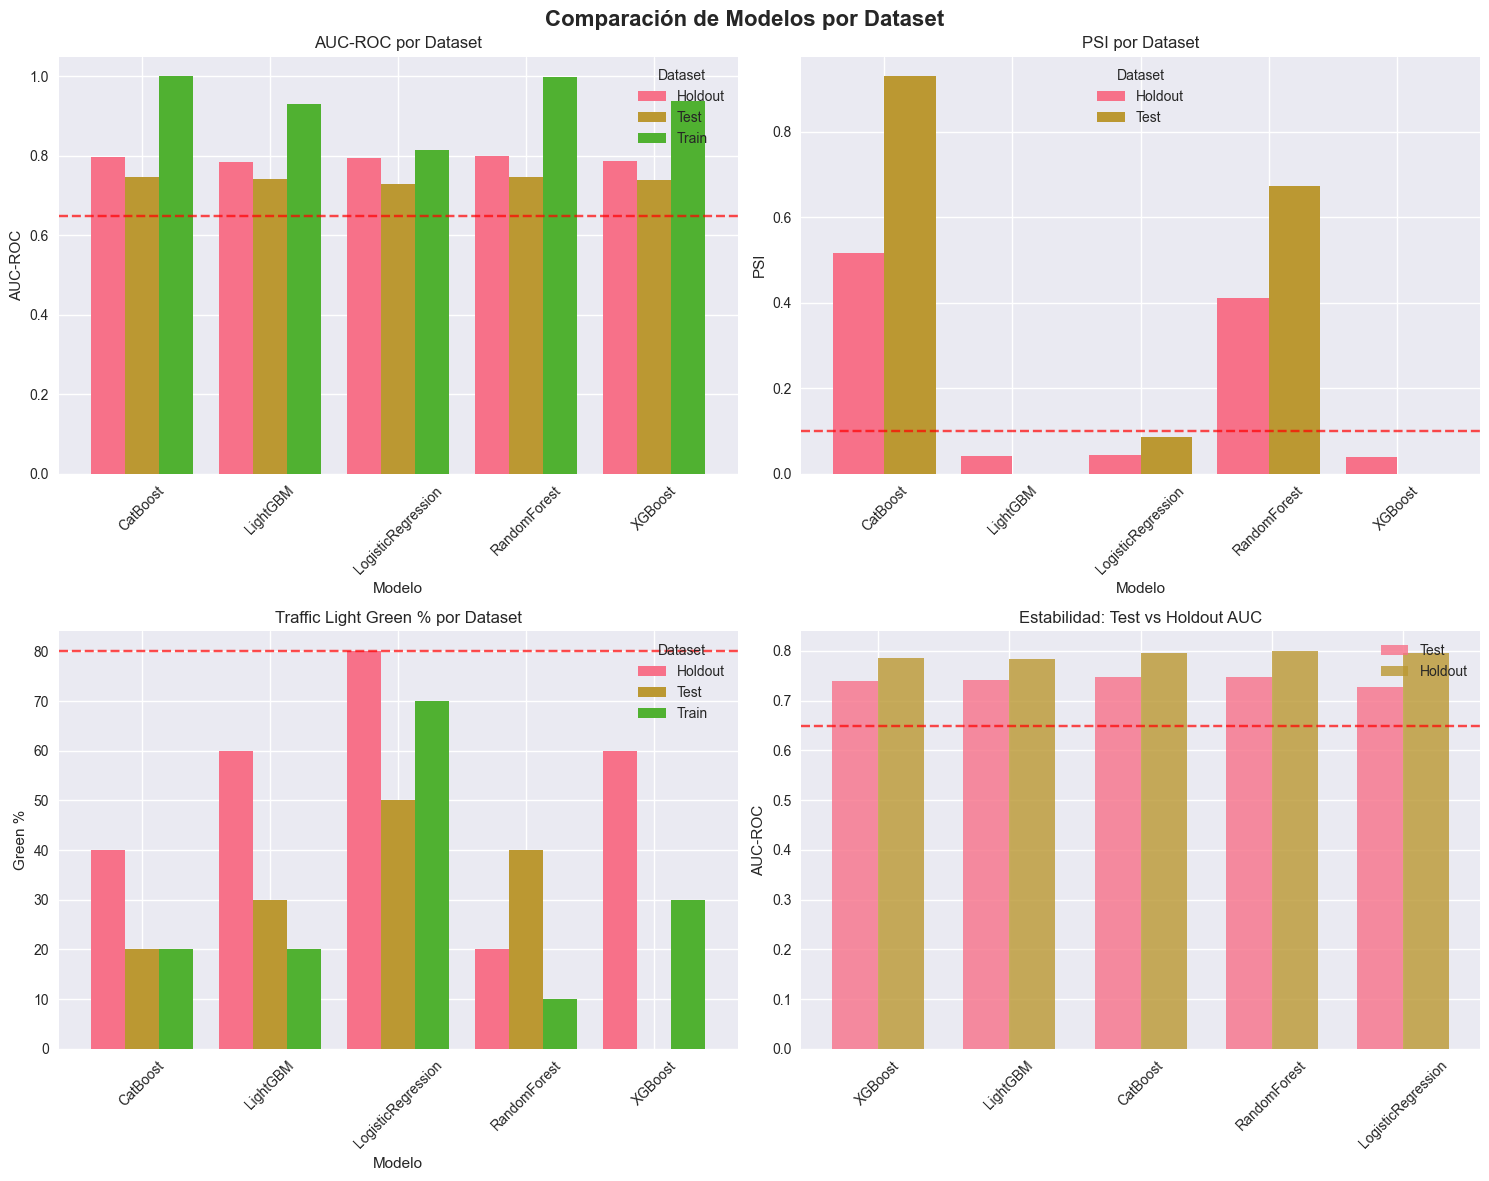

✅ Visualizaciones completadas


In [17]:
# Visualizaciones
print("📊 CREANDO VISUALIZACIONES...")

# Configurar subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparación de Modelos por Dataset', fontsize=16, fontweight='bold')

# 1. AUC-ROC por dataset
ax1 = axes[0, 0]
pivot_auc = comparison_df.pivot(index='Modelo', columns='Dataset', values='AUC-ROC')
pivot_auc.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('AUC-ROC por Dataset')
ax1.set_ylabel('AUC-ROC')
ax1.legend(title='Dataset')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=0.65, color='red', linestyle='--', alpha=0.7, label='Umbral (0.65)')

# 2. PSI por dataset (solo test y holdout)
ax2 = axes[0, 1]
psi_data = comparison_df[comparison_df['Dataset'].isin(['Test', 'Holdout'])]
pivot_psi = psi_data.pivot(index='Modelo', columns='Dataset', values='PSI')
pivot_psi.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('PSI por Dataset')
ax2.set_ylabel('PSI')
ax2.legend(title='Dataset')
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=0.10, color='red', linestyle='--', alpha=0.7, label='Umbral (0.10)')

# 3. Traffic Light Green % por dataset
ax3 = axes[1, 0]
pivot_green = comparison_df.pivot(index='Modelo', columns='Dataset', values='Traffic_Light_Green_%')
pivot_green.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Traffic Light Green % por Dataset')
ax3.set_ylabel('Green %')
ax3.legend(title='Dataset')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='Umbral (80%)')

# 4. Comparación de estabilidad (AUC Test vs Holdout)
ax4 = axes[1, 1]
test_auc = comparison_df[comparison_df['Dataset'] == 'Test']['AUC-ROC'].values
holdout_auc = comparison_df[comparison_df['Dataset'] == 'Holdout']['AUC-ROC'].values
models_list = comparison_df[comparison_df['Dataset'] == 'Test']['Modelo'].values

x = np.arange(len(models_list))
width = 0.35

ax4.bar(x - width/2, test_auc, width, label='Test', alpha=0.8)
ax4.bar(x + width/2, holdout_auc, width, label='Holdout', alpha=0.8)

ax4.set_title('Estabilidad: Test vs Holdout AUC')
ax4.set_ylabel('AUC-ROC')
ax4.set_xticks(x)
ax4.set_xticklabels(models_list, rotation=45)
ax4.legend()
ax4.axhline(y=0.65, color='red', linestyle='--', alpha=0.7, label='Umbral (0.65)')

plt.tight_layout()
plt.show()

print("✅ Visualizaciones completadas")


In [18]:
# Análisis detallado del mejor modelo
print("🏆 ANÁLISIS DEL MEJOR MODELO")
print("="*50)

# Encontrar el mejor modelo basado en AUC en holdout
holdout_results = comparison_df[comparison_df['Dataset'] == 'Holdout']
best_model_name = holdout_results.loc[holdout_results['AUC-ROC'].idxmax(), 'Modelo']
best_model_auc = holdout_results['AUC-ROC'].max()

print(f"🥇 Mejor modelo: {best_model_name}")
print(f"📊 Mejor AUC en Holdout: {best_model_auc:.4f}")

# Mostrar métricas detalladas del mejor modelo
best_model_results = results[best_model_name]

print(f"\n📈 MÉTRICAS DETALLADAS DE {best_model_name.upper()}:")
print("-" * 50)

for dataset, metrics in best_model_results.items():
    print(f"\n{dataset.upper()}:")
    print(f"   AUC-ROC: {metrics['auc_roc']:.4f}")
    if 'psi' in metrics:
        print(f"   PSI: {metrics['psi']:.4f}")
    print(f"   Traffic Light:")
    print(f"      Verde: {metrics['traffic_light']['green_percentage']:.1f}%")
    print(f"      Amarillo: {metrics['traffic_light']['yellow_percentage']:.1f}%")
    print(f"      Rojo: {metrics['traffic_light']['red_percentage']:.1f}%")


🏆 ANÁLISIS DEL MEJOR MODELO
🥇 Mejor modelo: RandomForest
📊 Mejor AUC en Holdout: 0.7992

📈 MÉTRICAS DETALLADAS DE RANDOMFOREST:
--------------------------------------------------

TRAIN:
   AUC-ROC: 0.9986
   Traffic Light:
      Verde: 10.0%
      Amarillo: 20.0%
      Rojo: 70.0%

TEST:
   AUC-ROC: 0.7471
   PSI: 0.6720
   Traffic Light:
      Verde: 40.0%
      Amarillo: 30.0%
      Rojo: 30.0%

HOLDOUT:
   AUC-ROC: 0.7992
   PSI: 0.4112
   Traffic Light:
      Verde: 20.0%
      Amarillo: 40.0%
      Rojo: 40.0%


In [ ]:
# Resumen ejecutivo
print("📋 RESUMEN EJECUTIVO")
print("="*50)

# Estadísticas generales
print(f"\n📊 ESTADÍSTICAS GENERALES:")
print(f"   Total de modelos evaluados: {len(trained_models)}")
print(f"   Mejor AUC en Holdout: {best_model_auc:.4f}")
print(f"   Modelos que superan umbral AUC (0.65): {len(holdout_results[holdout_results['AUC-ROC'] >= 0.65])}")

# Análisis de estabilidad
print(f"\n🔄 ANÁLISIS DE ESTABILIDAD:")
for model_name in trained_models.keys():
    test_auc = comparison_df[(comparison_df['Modelo'] == model_name) & (comparison_df['Dataset'] == 'Test')]['AUC-ROC'].iloc[0]
    holdout_auc = comparison_df[(comparison_df['Modelo'] == model_name) & (comparison_df['Dataset'] == 'Holdout')]['AUC-ROC'].iloc[0]
    stability = abs(test_auc - holdout_auc)
    
    print(f"   {model_name}: {stability:.4f} ({'✅ Estable' if stability < 0.05 else '⚠️ Inestable'})")

# Recomendaciones
print(f"\n💡 RECOMENDACIONES:")
print(f"   1. Modelo recomendado: {best_model_name}")
print(f"   2. AUC en Holdout: {best_model_auc:.4f} ({'✅ Cumple' if best_model_auc >= 0.65 else '❌ No cumple'} umbral)")

if best_model_auc < 0.65:
    print(f"   3. ⚠️ Ningún modelo alcanza el umbral mínimo de AUC (0.65)")
    print(f"      Considerar: Feature engineering, más datos, o modelos más complejos")

print(f"\n✅ Análisis completo finalizado")


In [ ]:
# Análisis de Overfitting
print("🔍 ANÁLISIS DE OVERFITTING")
print("="*50)

# Calcular gaps de overfitting
overfitting_analysis = []

for model_name in trained_models.keys():
    train_auc = comparison_df[(comparison_df['Modelo'] == model_name) & (comparison_df['Dataset'] == 'Train')]['AUC-ROC'].iloc[0]
    test_auc = comparison_df[(comparison_df['Modelo'] == model_name) & (comparison_df['Dataset'] == 'Test')]['AUC-ROC'].iloc[0]
    holdout_auc = comparison_df[(comparison_df['Modelo'] == model_name) & (comparison_df['Dataset'] == 'Holdout')]['AUC-ROC'].iloc[0]
    
    train_test_gap = train_auc - test_auc
    train_holdout_gap = train_auc - holdout_auc
    test_holdout_gap = test_auc - holdout_auc
    
    overfitting_analysis.append({
        'Modelo': model_name,
        'Train_AUC': train_auc,
        'Test_AUC': test_auc,
        'Holdout_AUC': holdout_auc,
        'Train_Test_Gap': train_test_gap,
        'Train_Holdout_Gap': train_holdout_gap,
        'Test_Holdout_Gap': test_holdout_gap,
        'Overfitting_Level': 'Alto' if train_test_gap > 0.05 else 'Medio' if train_test_gap > 0.02 else 'Bajo'
    })

overfitting_df = pd.DataFrame(overfitting_analysis)

print("📊 GAPS DE OVERFITTING:")
print("-" * 50)
display(overfitting_df.round(4))

# Identificar modelos con menos overfitting
best_generalization = overfitting_df.loc[overfitting_df['Train_Test_Gap'].idxmin()]
print(f"\n🏆 MEJOR GENERALIZACIÓN:")
print(f"   Modelo: {best_generalization['Modelo']}")
print(f"   Train-Test Gap: {best_generalization['Train_Test_Gap']:.4f}")
print(f"   Nivel de Overfitting: {best_generalization['Overfitting_Level']}")

# Visualización de overfitting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gap Train-Test
ax1 = axes[0]
bars1 = ax1.bar(overfitting_df['Modelo'], overfitting_df['Train_Test_Gap'])
ax1.set_title('Gap de Overfitting: Train vs Test')
ax1.set_ylabel('AUC Gap')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Umbral Medio (0.02)')
ax1.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Umbral Alto (0.05)')
ax1.legend()

# Colorear barras según nivel de overfitting
for i, (bar, level) in enumerate(zip(bars1, overfitting_df['Overfitting_Level'])):
    if level == 'Alto':
        bar.set_color('red')
    elif level == 'Medio':
        bar.set_color('orange')
    else:
        bar.set_color('green')

# Comparación Train/Test/Holdout
ax2 = axes[1]
x = np.arange(len(overfitting_df))
width = 0.25

ax2.bar(x - width, overfitting_df['Train_AUC'], width, label='Train', alpha=0.8)
ax2.bar(x, overfitting_df['Test_AUC'], width, label='Test', alpha=0.8)
ax2.bar(x + width, overfitting_df['Holdout_AUC'], width, label='Holdout', alpha=0.8)

ax2.set_title('Comparación AUC por Dataset')
ax2.set_ylabel('AUC-ROC')
ax2.set_xticks(x)
ax2.set_xticklabels(overfitting_df['Modelo'], rotation=45)
ax2.legend()
ax2.axhline(y=0.65, color='red', linestyle='--', alpha=0.7, label='Umbral (0.65)')

plt.tight_layout()
plt.show()

print("✅ Análisis de overfitting completado")


In [ ]:
# Próximos pasos: Integración con datos sintéticos
print("🚀 PRÓXIMOS PASOS: INTEGRACIÓN CON DATOS SINTÉTICOS")
print("="*60)

print("📋 PLAN DE INTEGRACIÓN:")
print("1. Cargar datos sintéticos generados en Fase 2")
print("2. Combinar datos reales y sintéticos en diferentes proporciones")
print("3. Re-entrenar modelos con datos combinados")
print("4. Comparar performance vs baseline (solo datos reales)")
print("5. Evaluar impacto de datos sintéticos en overfitting")

print(f"\n🎯 ESTRATEGIAS DE COMBINACIÓN:")
print("   - Estrategia 1: 70% real + 30% sintético")
print("   - Estrategia 2: 50% real + 50% sintético")
print("   - Estrategia 3: 30% real + 70% sintético")
print("   - Estrategia 4: Solo datos sintéticos (validación extrema)")

print(f"\n📊 MÉTRICAS A EVALUAR:")
print("   - Reducción de overfitting (Train-Test gap)")
print("   - Mejora en generalización (Holdout performance)")
print("   - Estabilidad (PSI)")
print("   - Calibración (Traffic Light)")

print(f"\n🔬 EXPERIMENTOS PLANIFICADOS:")
print("   - Comparar generadores (GAN vs No-GAN)")
print("   - Evaluar diferentes librerías (SDV, SynthCity, YData)")
print("   - Analizar impacto del tamaño de datos sintéticos")
print("   - Validar con diferentes segmentos de riesgo")

print(f"\n✅ Notebook listo para integración con datos sintéticos")
print(f"   📁 Datos sintéticos esperados en: {DATA_DIR / 'synthetic'}")
print(f"   📊 Resultados guardados en: {RESULTS_DIR}")
print(f"   🎯 Baseline establecido con modelos optimizados")
